## URBAN HEALTH AND MEGACITIES: THE CASE OF NEW DELHI

![Title](Intro/img/Case_studies.png)

# USE CASE 1: Nighttime Lights 
## Creating nighttime light maps with color blending

This use case demonstrates how to create nighttime light variation maps over a time interval (from 2019 to 2022) with additive color blending for studying the distribution of artificial lighting in urban and rural regions, offering insights into urbanization, infrastructure development, and socio-economic activity.
The Nighttime Light Levels indicator can be explored on the EO Dashboard by selecting the EXPLORE DATASETS mode and choosing [Night lights indicators](https://eodashboard.org/explore?indicator=NTLU&x=12142837.23019&y=4137471.98879&z=5.69238). 

The study has been carried out by **Bumpei Tojo PhD (Associate Professor), School of International and Area Studies, Tokyo University of Foreign Studies, Japan**.

The **PLES Engineering team** (supporting *ESA Green Solutions Division*, EOP-SG) developed the blending algorithm with the current Notebook implementation and data ingestion on the dashboard (contacts: **Federico Rondoni**, f.rondoni@stariongroup.eu, **Diego Moglioni**, d.moglioni@stariongroup.eu).  

![title](Nightlights/img/night_india.JPG)

Example of a nighttime light map covering India during 2019-2022, representing areas where a decrease in nighttime light level occurred (indicating a presumed reduction in social activity) in red, and areas where an increase occurred (indicating a presumed increase in social activity) in blue.

### Input data:
* This product was developed by JAXA by aggregating the data from the Visible Infrared Imaging Radiometer Suite (VIIRS, onboard the Suomi NPP satellite) on a semi-annual basis (using median image generation) with 10-degree lat/lon (geographic) grid h-v tile as Geo Tiff files.
* The tiles are 2400 x 2400 pixels, with pixel size of 0.004166 degrees (~464 m at the equator).
* Metric: nighttime radiance (measured in watts per square centimeter per steradian, [W/cm²/sr]), which represents the brightness of artificial lighting.

**VIIRS 10-degree tile scheme**

![VIIRS tiling scheme.JPG](Nightlights/img/VIIRS_tiling_scheme.jpg)



### Running environment:
* This notebook can be run by installing the provided Anaconda Python environment (**notebook-env.yml**).

### Importing Python libraries

In [1]:
#Import libraries
import os
import sys
import re
import numpy as np
import rasterio
import rioxarray as rxr
import subprocess
from subprocess import Popen, PIPE
import tempfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import json
from ipyleaflet import Map, ImageOverlay, basemaps

### Defining working folders

In [2]:
input_dir = "input"
input_path = os.path.join(os.getcwd(), "Nightlights", input_dir)

output_urban = "output"
urban_path = os.path.join(os.getcwd(), "Nightlights", output_urban)

# Create output dir
os.makedirs(urban_path, exist_ok=True)

### Visualizing input data

In [3]:
pattern = re.compile(r"h(\d+)v(\d+)_(\d{4})_(\d)H_median\.tif")

for root, _, files in os.walk(input_path):
    grouped_files = {}
    
    # Grouping files by h and v
    for file in files:
        match = pattern.match(file)
        if match:
            h, v, year, H = match.groups()
            key = (h, v)
            if key not in grouped_files:
                grouped_files[key] = []
            grouped_files[key].append((year, H, os.path.join(root, file))) 
    
    # Process files for plotting
    for (h, v), file_group in grouped_files.items():
        file_group

tuplelist2dict = {c:{'year':a,'half':b} for a,b,c in file_group}
sorted_dict = {}

grid_tile = None
for item in sorted(tuplelist2dict, key = lambda k: (tuplelist2dict[k]['year'], tuplelist2dict[k]['half'])):
    sorted_dict.update({item:tuplelist2dict[item]})
    grid_tile = item.split('/')[-1].split('_')[0]
#print(sorted_dict)

In [4]:
def plot_figures(figures, nrows = 1, ncols=1, factor = 1., clip_range = None, **kwargs):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 15))
    for idx,file_name in enumerate(figures):
        title = file_name.split('/')[-1]
        title = title.replace("_median.tif", "")
        axeslist.ravel()[idx].imshow(np.clip(mpimg.imread(file_name)*factor, *clip_range), **kwargs) # cmap=plt.gray(), cmap='Greys'
        axeslist.ravel()[idx].set_title(title)
        axeslist.ravel()[idx].set_axis_off()
    fig.suptitle(r'Median nighttime light level [$Wcm^{-2}sr^{-1}$]', fontsize=20)
    #plt.tight_layout() 

    

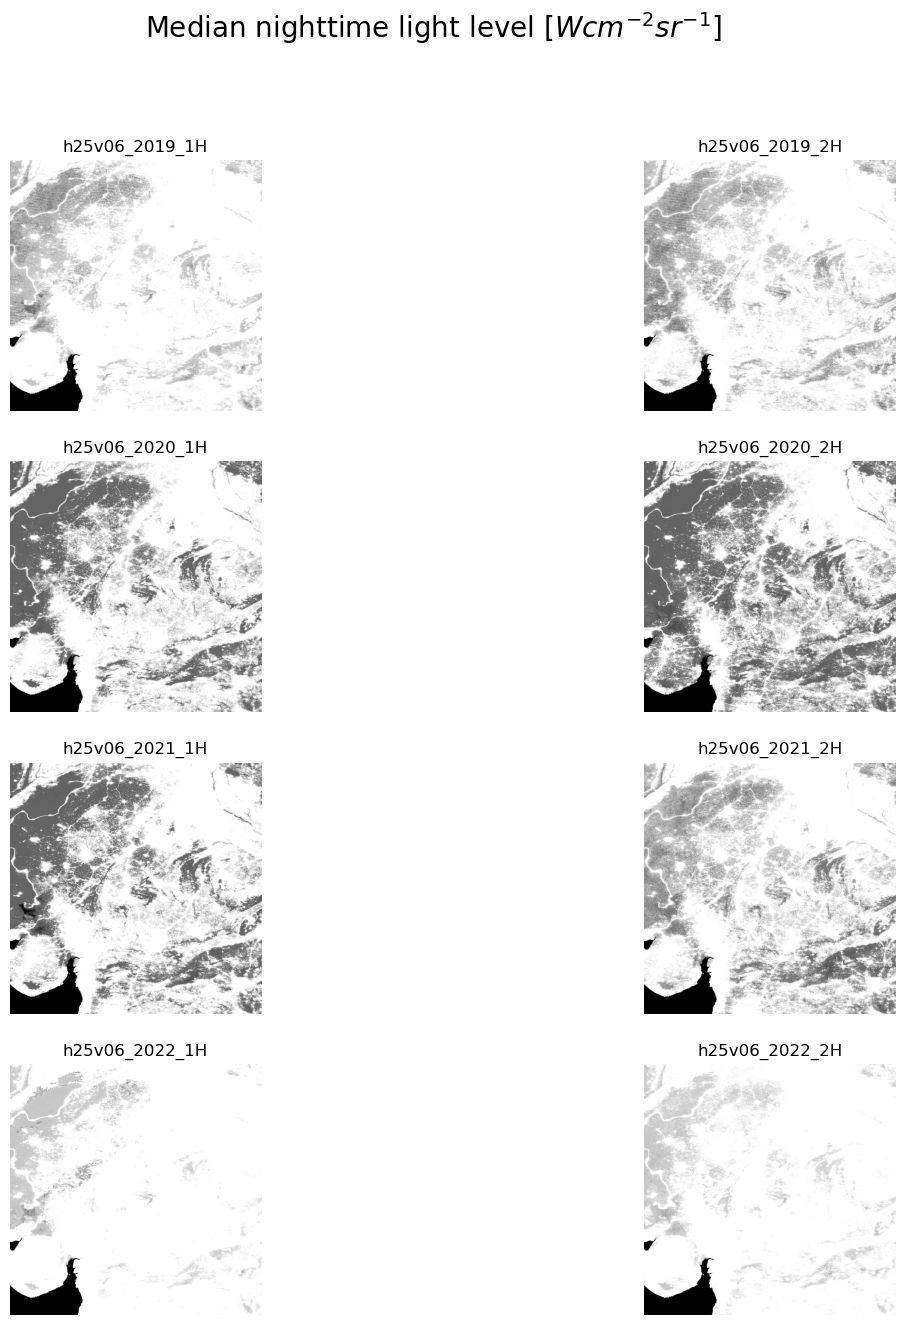

In [5]:
plot_figures(sorted_dict, 4, 2, clip_range=(0,1), factor=100./255.)

### Applying color blending 

Additive color blending involves mixing the primary colors of light, red (R), green (G), and blue (B), while adjusting their luminance levels. By manipulating the luminance of these colors, a wide range of hues can be achieved, with the key characteristic being that combining all three colors results in white.

Technique
- maximum pixel value of images for 2019 (brightest pixel values) is assigned to red (R)
- minimum pixel value of images for 2020-2021 (darkest pixel values) is assigned to green (G)
- maximum pixel value of images for 2022 (brightest pixel values) is assigned to blue (B)

Output
- regions where a decrease in nighttime light level occurred are displayed in red
- areas that experienced an increase (presumed to indicate an increase in social activity) are shown in blue
- regions where there was no significant change throughout the pandemic are displayed in a gradient from gray to white.

In [6]:
pattern = re.compile(r"h(\d+)v(\d+)_(\d{4})_(\d)H_median\.tif")


def read_and_preprocess(file):
    with rasterio.open(file) as src:
        img = src.read(1)
        img = np.nan_to_num(img, nan=0)  # Replace NaNs with zeros
        return img, src.profile

    
def additive_blending(grouped_files):
    # Process each group of files for blending
    for (h, v), file_group in grouped_files.items():
        # Initialize arrays to store the maximum and minimum values for each year
        max_2019 = None
        min_2020_2021 = None
        max_2022 = None
        
        for year, H, file in file_group:
            img, profile = read_and_preprocess(file)
            
            if year == '2019':
                if max_2019 is None:
                    max_2019 = img
                else:
                    max_2019 = np.maximum(max_2019, img)
            elif year in ['2020', '2021']:
                if min_2020_2021 is None:
                    min_2020_2021 = img
                else:
                    min_2020_2021 = np.minimum(min_2020_2021, img)
            elif year == '2022':
                if max_2022 is None:
                    max_2022 = img
                else:
                    max_2022 = np.maximum(max_2022, img)
                                  
    # Create the blended image using the specified blending technique
    blended_img = np.zeros((max_2019.shape[0], max_2019.shape[1], 3), dtype=np.float32)
    blended_img[:, :, 0] = max_2019.astype(np.float32)  # Red band: maximum of 2019
    blended_img[:, :, 1] = min_2020_2021.astype(np.float32)  # Green band: minimum of 2020-2021 compared
    blended_img[:, :, 2] = max_2022.astype(np.float32)  # Blue band: maximum of 2022
    
    return blended_img, profile        

In [7]:
# Grouping files per (h,v) tiles and years span
grouped_files = {}
for root, _, files in os.walk(input_path):
    
    
    # Group files by h and v
    for file in files:
        match = pattern.match(file)
        if match:
            h, v, year, H = match.groups()
            key = (h, v)
            if key not in grouped_files:
                grouped_files[key] = []
            grouped_files[key].append((year, H, os.path.join(root, file)))


# blending           
blended_img, profile = additive_blending(grouped_files)

### Employing "urban" stretch processing

The purpose of the stretch processing is to emphasize the nighttime light level of each band (corresponding to 2019, 2020-21, and 2022), focusing on:
- "urban" nighttime light levels: the display range of each band is adjusted to 25-1000 [watts·cm-2·sr-1], emphasizing brighter areas

In [8]:
# Urban stretch processing: Emphasize brighter areas
def urban_stretch_processing(band):
    min_val = 25
    max_val = 1000
    band = np.clip(band, min_val, max_val)
    band = (band - min_val) / (max_val - min_val) * 255
    return band.astype(np.uint8)

# Apply urban stretch processing to each band
blended_img[:, :, 0] = urban_stretch_processing(blended_img[:, :, 0])
blended_img[:, :, 1] = urban_stretch_processing(blended_img[:, :, 1])
blended_img[:, :, 2] = urban_stretch_processing(blended_img[:, :, 2])
        
# Update the profile for a 3-band image and set nodata value to None
profile.update(count=3, dtype=rasterio.uint8, nodata=None)

### Plotting blended image

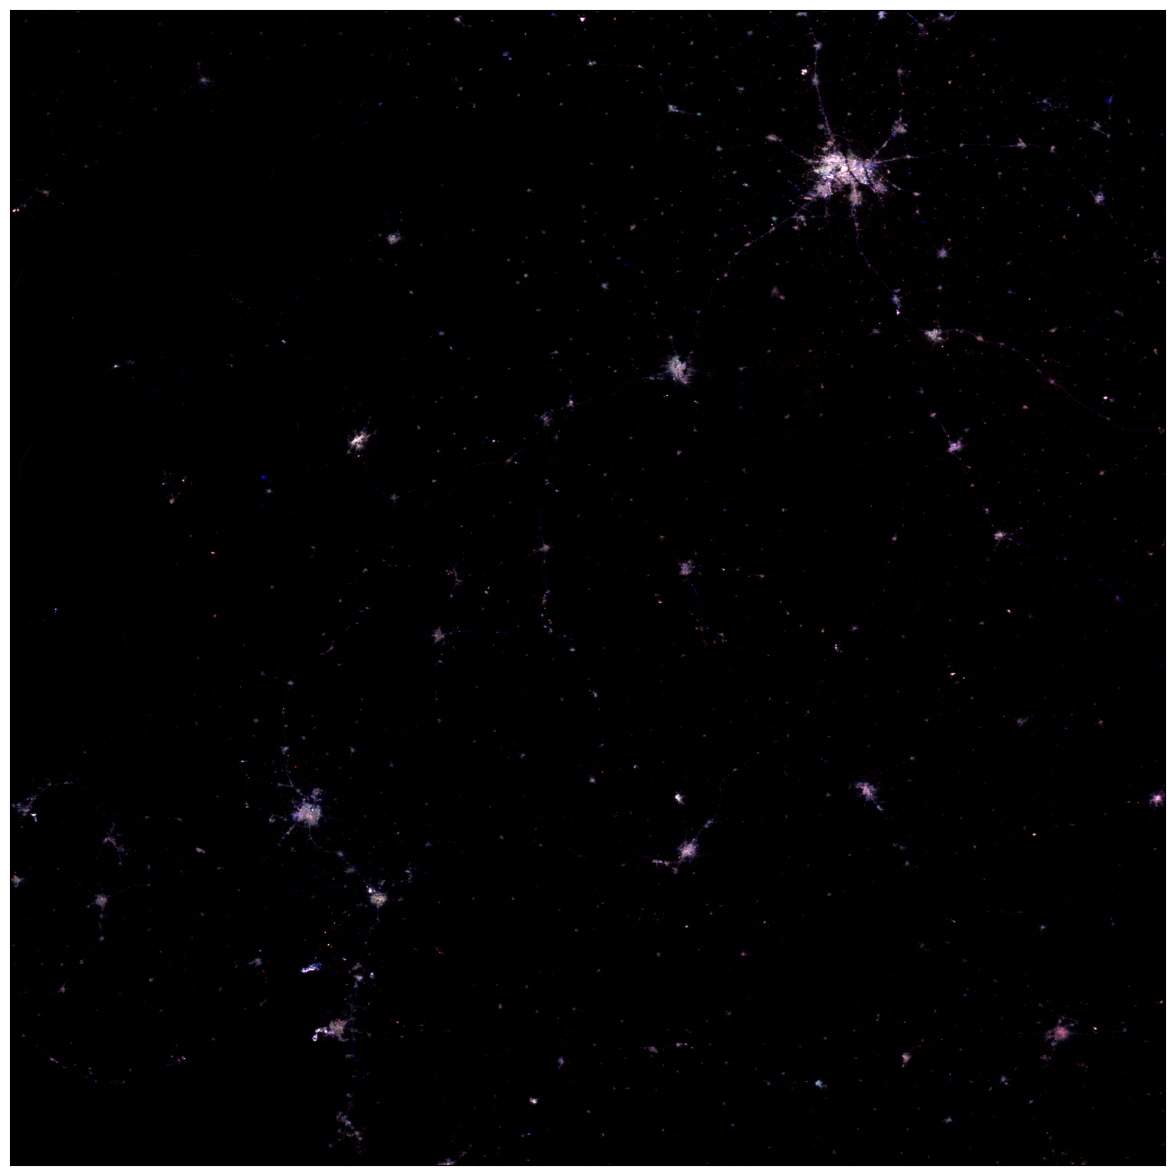

In [9]:
def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])


plot_image(blended_img, factor=1.5/255., clip_range=(0,1))

### Overlaying with an interactive map

Saving blended image as Cloud Optimized GeoTIFF

In [10]:
# Exporting output as COG file 
res_name = f"Nighttimelevel_Urban_{grid_tile}_2019-2022.tif"
output_cog = os.path.join(urban_path, res_name)


# Write the blended image directly to a temporary file
with tempfile.NamedTemporaryFile(suffix=".tif") as temp_file:
    with rasterio.open(temp_file.name, "w", **profile) as dst:
        dst.write(blended_img[:, :, 0], 1)
        dst.write(blended_img[:, :, 1], 2)
        dst.write(blended_img[:, :, 2], 3)

    subprocess.run([
        "gdal_translate", "-of", "COG",
        "-co", "COMPRESS=DEFLATE",
        "-co", "BLOCKSIZE=512",
        "-co", "RESAMPLING=NEAREST",
        "-co", "OVERVIEWS=IGNORE_EXISTING",
        temp_file.name,
        output_cog
    ])

print(f"COG file saved as {output_cog}")

Input file size is 2400, 2400
0...10...20...30...40...50...60...70...80...90...100 - done.
COG file saved as /home/undeadfairy/Nightlights/output/Nighttimelevel_Urban_h25v06_2019-2022.tif


Extracting bounding-box coordinates

In [11]:
p1 = Popen(["gdalinfo", "-json", output_cog, "-mm"], stdout=PIPE)
output = p1.communicate()[0]
dec_out = output.decode('utf-8')
j_str = json.loads(dec_out)
bbox = j_str['cornerCoordinates']
ll = bbox['lowerLeft']  # SW coo
ur = bbox['upperRight'] # NE coo
center = bbox['center']

Adding alpha channel to the blended image 

In [12]:
def almostEquals(a,b,thres=50):
    return all(abs(a[i]-b[i])<thres for i in range(len(a)))


image = Image.open(output_cog).convert('RGBA')
pixeldata = list(image.getdata())


for i,pixel in enumerate(pixeldata):
    if almostEquals(pixel[:3], (0,0,0)):
        pixeldata[i] = (0,0,0,0)


image.putdata(pixeldata)
png_path = os.path.join(urban_path, res_name.replace(".tif",".png"))
res = image.save(png_path)
#os.path.abspath(res)
abs_path = os.path.abspath(png_path)
work_dir = os.getcwd()
id_ = work_dir.split('/')[2]
base_url = os.path.join('https://hub.eox.at/user',id_,'files')
#base_url
abs_path = '/'.join(abs_path.split('/')[3:])
print(abs_path)
print(base_url)
#abs_path
print(os.path.join(base_url,abs_path))


Nightlights/output/Nighttimelevel_Urban_h25v06_2019-2022.png
https://hub.eox.at/user/undeadfairy/files
https://hub.eox.at/user/undeadfairy/files/Nightlights/output/Nighttimelevel_Urban_h25v06_2019-2022.png


Overlay with OpenStreetMap 

In [13]:
m = Map(basemap=basemaps.CartoDB.DarkMatter, center=(center[1], center[0]), zoom=6)
osm_url = os.path.join(base_url,abs_path)
image = ImageOverlay(
        url=osm_url, #url="https://hub.eox.at/user/<id>/files/<path_to_png>
        bounds=((ll[1], ll[0]), (ur[1], ur[0])) # SW and NE corners
                    )
m.add_layer(image);
m

Map(center=[25.0, 75.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

Using additive color blending images to focus on urban areas in India, in particular the North-West part comprising New Delhi, Jaipur, Agra, Gwalior, ...

### Alternative stretch processing approaches

- "Rural" nighttime light levels: setting each band's display range to 0-50 [Watts·cm-2·sr-1] to emphasize darker areas
- For a broader focus (from rural to urban areas): applying a log10 transformation to the values of each band with a display range set to 0-3.6 (equivalent to 0-3981 [Watts·cm-2·sr-1])

### Final remarks

This product has been specifically designed for utilization by researchers in applied scientific fields.
**Potential applications** are being explored in environmental and social issue studies, such as:
* **disaster recovery**
* **energy**
* **urban land use changes**
* **conflicts**
* **migration**
* **monitoring of illegal, unreported activities**

### To learn more

The presented approach is often referenced in scientific and public health research. For example, Bunpei Tojo (2021) used Nightlights data in the study "Application of Earth observation satellite data to public health: Comparison of night light (VIIRS) and solar radiation (SGLI) and domestic COVID-19 epidemic," presented at the 12th Federation of Science and Technology conference, to analyze the relationship between nighttime light intensity and public health factors.
https://doi.org/10.11487/oukan.2021.0_B-4-4.

# USE CASE 2: Air Pollution
##  Monitoring NO2 concentrations over Northern India

Air quality is poor across India, but especially poor in Northern India due to a mix of human activity and seasonal weather conditions:
* **Vehicle emissions**: The city's high population density results in heavy traffic and significant pollution from older and poorly maintained vehicles. Increased investment in mass transportation and stricter fuel efficiency enforcement could help mitigate these issues in future.
* **Industrial and construction dust**: Industrial operations and ongoing construction projects release fine particulate matter into the air.
* **Home heating**: Coal, firewood, and diesel generator use can contribute to poor air quality.
* **Weather patterns**: Chillier temperatures, low wind speeds, and heavy air trap pollutants close to the ground during colder months, worsening smog.
* **Crop stubble burning**: Farmers in neighboring states including Bihar, Haryana, and Uttar Pradesh burn agricultural waste, contributing to particulate pollution

Combined, these factors create a toxic atmosphere. Air quality is particularly dangerous during the winter months, when weather conditions exacerbate pollution.

![title](Air_pollution/img/Northern_India-air_pollution.JPG)


In particular, Delhi and large parts of **North India** experienced a significant **air quality crisis towards the end of 2024**, with air quality reaching the "Severe" and "Hazardous" categories, leading to the implementation of pollution control measures like Graded Response Action Plan 3 (GRAP 3). The air quality deterioration was caused by factors like high humidity, low wind speeds, and continued agricultural burning, which trapped fine particulate matter (PM2.5) in the atmosphere. This resulted in a public health emergency, with extreme pollution posing serious health risks, especially to children and the elderly, and leading to health advisories, school closures, and even flight diversions.

### Visualizing the AoI (Gurugram, South-West of New Delhi)

In [15]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import subprocess
import json
import requests
import pandas as pd
import os 
import IPython.display
from datetime import datetime
import matplotlib.pyplot as plt

# Sentinel Hub
from sentinelhub import (SHConfig, DataCollection, Geometry, BBox, CRS, SentinelHubCatalog,
                         SentinelHubRequest, filter_times, bbox_to_dimensions, MimeType, 
                         SentinelHubBYOC, ByocCollection, ByocTile, ByocCollectionAdditionalData,
                         DownloadFailedException, CRS, SentinelHubStatistical)

In [16]:
# Gurugram coordinates
top_left_x =  76.9602268594042
top_left_y = 28.5355222251629
bottom_right_x = 77.11128887112295 
bottom_right_y = 28.394875392026698

bbox = [   
  top_left_x,
  bottom_right_y,
  bottom_right_x,
  top_left_y
        ]

# Bbox EPSG
bbox_epsg = 4326

In [17]:
# Plotting the bounding box on a map

IPython.display.GeoJSON(BBox(bbox,crs=bbox_epsg).get_geojson())

<IPython.display.GeoJSON object>

### Use SH statistical API request to access NO2 data for the selected AoI

The Statistical API (or shortly "Stats API") enables you to get statistics calculated based on satellite imagery without having to download images.
In your Statistical API request, you can specify:
* area of interest (AoI)
* time period
* evalscript
* data collection
* statistics to be calculated

The requested statistics are returned in the API response. Further details are to be found on the corresponding [SH documentation](https://docs.sentinel-hub.com/api/latest/api/statistical/).

In [18]:
bbox = [   
  top_left_x,
  top_left_y,
  bottom_right_x,
  bottom_right_y,
        ]

data_collection = "byoc-972e67a7-2ca8-4bf6-964a-11fe772e3ac2"
date_from = "2024-11-01T00:00:00.000Z"
date_to = "2025-02-28T00:00:00.000Z"

In [19]:
data_req = {
  "input": {
    "bounds": {
      "bbox": bbox
    },
    "data": [
      {
        "dataFilter": {},
        "type": data_collection
      }
    ]
  },
  "aggregation": {
    "evalscript": "//VERSION=3\nfunction setup() {\n    return {\n      input: [{\n        bands: [\n          \"tropno2\",\n          \"dataMask\"\n        ]\n      }],\n      output: [\n        {\n          id: \"data\",\n          bands: 1,\n          sampleType: \"FLOAT32\"\n        },\n        {\n          id: \"dataMask\",\n          bands: 1\n        }\n      ]\n    }\n  }\n  function evaluatePixel(samples) {\n    let validValue = 1\n    // data sanitation\n    if (samples.tropno2 >= 1e20 ){\n        validValue = 0\n    }\n    let index = samples.tropno2;\n    return {\n      data:  [index],\n      dataMask: [samples.dataMask * validValue]\n    }\n  }\n",
    "timeRange": {
      "from": date_from,
      "to": date_to
    },
    "aggregationInterval": {
      "of": "P1D"
    },
    "width": 100,
    "height": 100
  },
  "calculations": {
    "default": {}
  }
}


In [20]:
# Creating a session

# OAuth Client configuration
client_id = os.environ.get("SH_CLIENT_ID")
client_secret = os.environ.get("SH_CLIENT_SECRET") 

client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_secret=client_secret)

In [21]:
resp = oauth.post("https://services.sentinel-hub.com/api/v1/statistics",
                  headers={"Accept":"application/json","Content-Type":"application/json"},
                  json=data_req)
#print(resp.status_code, resp.text)


In [22]:
# Extracting stats from timeseries within the specified time interval
data_r = resp.json() # parsing response to json
time_axis = [datetime.strptime(entry["interval"]["from"], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y/%m/%d") for entry in data_r["data"]]
means = [float(entry['outputs']['data']['bands']['B0']['stats']['mean']) for entry in data_r["data"]]
std_devs = [float(entry['outputs']['data']['bands']['B0']['stats']['stDev']) for entry in data_r["data"]]
std_upper = [m+s for (m,s) in zip(means, std_devs)]
std_lower = [m-s for (m,s) in zip(means, std_devs)]

### Plotting the statistics for the NO2 timeseries

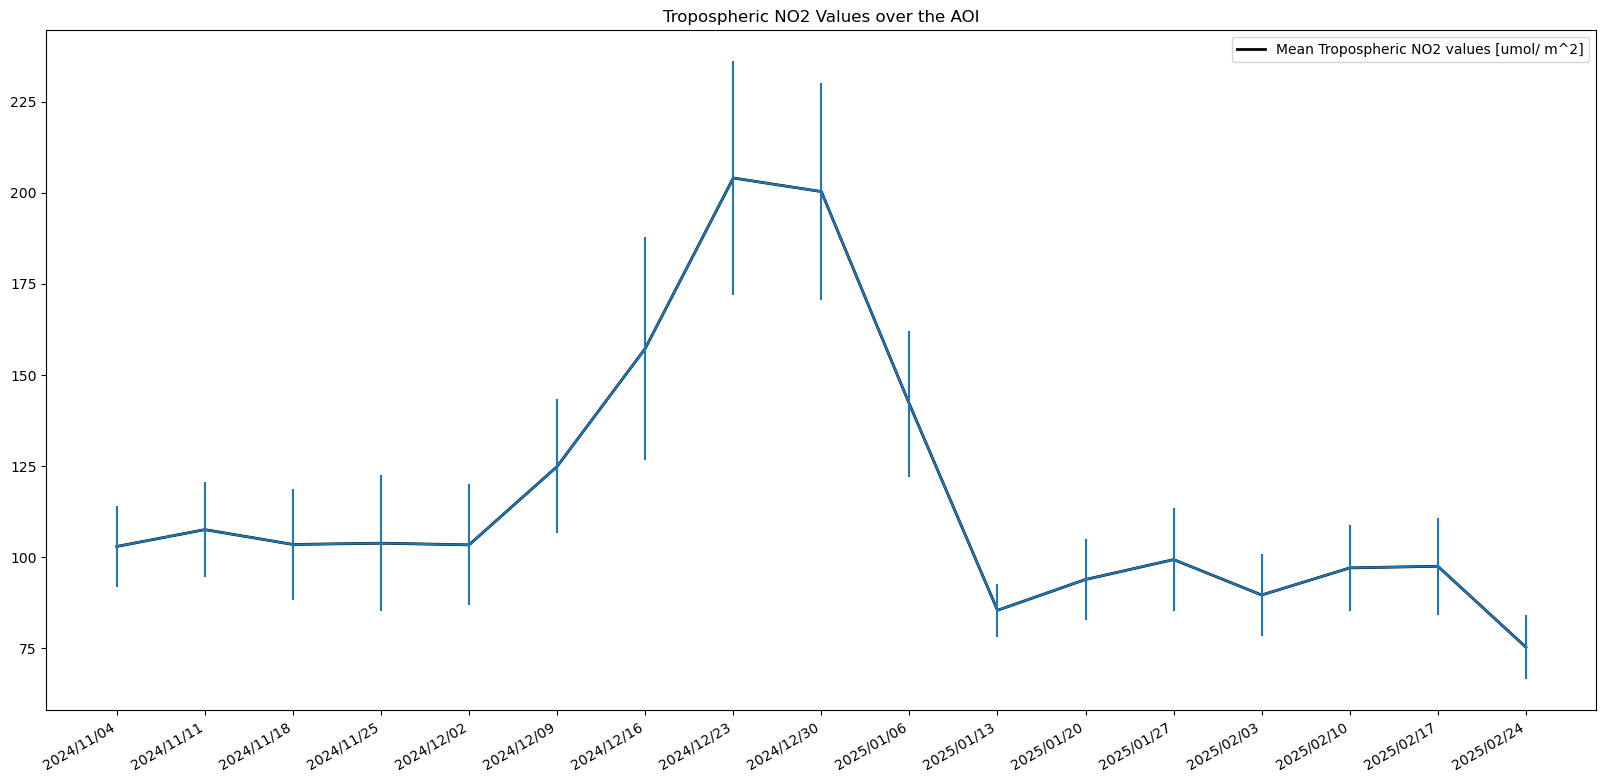

In [22]:
fig = plt.figure(figsize=(20,10))
# plot mean values 
plt.plot(time_axis, means, linestyle='solid', linewidth=2, color="black", label="Mean Tropospheric NO2 values [umol/ m^2]")

# plot standard deviation error bars
plt.errorbar(time_axis, means, yerr=std_devs, linestyle="-")

plt.title('Tropospheric NO2 Values over the AOI')
plt.legend()
fig.autofmt_xdate()

# Saving plot
output_no2 = "output"
output_no2_path = os.path.join(os.getcwd(), "Air_pollution", output_no2)
os.makedirs(output_no2_path, exist_ok=True)
plt.savefig(os.path.join(output_no2_path, 'NO2_Gurugram.png'))

plt.show()

The plot shows a spike in NO2 concentration over Gurugram in December 2024, when the significant air quality crisis in Northern India has been reported.
In particular, it can be noticed that the standard deviation starts increasing over this month with respect to the preceding and subsequent  time interval. 


# USE CASE 3: HEATWAVES
## Analyzing Land Surface Temperature with GCOM-C 'Shikisai' Satellite Data

In this use case, we will explore **GCOM (Global Change Observation Mission)** satellite data to analyze **Land Surface Temperature (LST)**. Specifically, we’ll look at data from the **GCOM-C** satellite, which is part of the Japan Aerospace Exploration Agency’s (**JAXA**) efforts to monitor global climate change. GCOM-C provides valuable information on various environmental factors, including temperature, vegetation, and water bodies, through its thermal infrared sensors.

Our focus will be on studying the **heatwave** that occurred in **New Delhi, India, in 2024**. In particular, the city experienced a significant temperature surge during the peak summer months. The temperature exceeded **45°C (113°F)**, causing severe disruptions to daily life, and raising concerns about the increasing frequency and intensity of heatwaves due to climate change.

By analyzing GCOM-C's satellite data, we can better understand the spatial distribution of land surface temperature during that period, as well as any emerging patterns that might indicate more frequent or severe heat events in the future.



### 3.1 Import libraries

In [23]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from osgeo import gdal
import requests
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from matplotlib.colors import LinearSegmentedColormap

### 3.2 About the data: storage and access
- **FIND DATA LOCATION:** To find where a data is stored, one can search throught the EODash https://github.com/ESA-eodashboards/eodashboard-catalog/tree/80bde3aac691e00edb963b785385056709dd18b4/collections 

- **DATA STORED AT WASABI:**  Our data is located at the following url https://s3.ap-northeast-1.wasabisys.com/je-pds/cog/v1/JAXA.G-Portal_GCOM-C.SGLI_standard.L3-LST.daytime.v3_global_monthly/2024-07/1/E000.00-E090.00/E000.00-N00.00-E090.00-N90.00-LST.tiff". This URL is hosted on **Wasabi, a cloud storage service**, which is known for providing affordable, high-performance cloud storage for large datasets, often used in scientific research or data-heavy projects. Wasabi is not affiliated to JAXA, provides does not charge for API requests. Wasabi's object storage service is built to be **100% bit-compatible with AWS S3**.
<div style="text-align: center;">
    <img src="https://a-us.storyblok.com/f/1019449/828x476/a741cde6a0/stacked-logo-full-color-rgb.png" width="100">
</div>

- **ABOUT DATASET:** The LST (Land Surface Temperature) data file corresponds to the daytime measurements taken by the SGLI sensor. It's a **monthly global dataset for July 2024**, indicating this is a time-series observation over a large area. To interpret the naming convention of the data: it contains the name of the variable, the month/year it is averaging and the represent the spatial coordinates of the bounding box it covers (0° to 90° East and 0° to 90° North).

<div style="text-align: center;">
    <img src="https://space.skyrocket.de/img_sat/gcom-c__1.jpg" width="100">
    <div style="font-size: small;">GCOM-C 'Shikisai'. Credit: JAXA</div>
</div>



### 3.3 A first look at the dataset

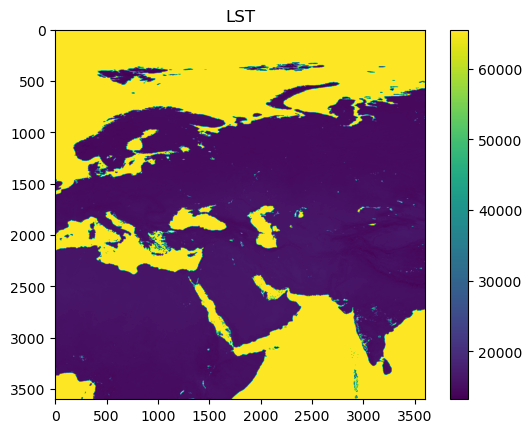

 - - - 
More information about the dataset:
 - - - 
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]] (0.0, 0.025, 0.0, 90.0, 0.0, -0.025)


In [24]:
# Location of URL stored on Wasabi 
url = "https://s3.ap-northeast-1.wasabisys.com/je-pds/cog/v1/JAXA.G-Portal_GCOM-C.SGLI_standard.L3-LST.daytime.v3_global_monthly/2024-07/1/E000.00-E090.00/E000.00-N00.00-E090.00-N90.00-LST.tiff"
# Downloads the file from the URL
response = requests.get(url)
# Saves file locally 
with open("Heatwaves/LST.tiff", "wb") as f:
    f.write(response.content)

# Opening the file with GDAL (library for geospatial raster data)
ds = gdal.Open("Heatwaves/LST.tiff")
# Gests the first (and in this case) only band refering to LST.
band = ds.GetRasterBand(1)
#Reads the raster into a NumPy array (a sort of matrix)
arr = band.ReadAsArray().astype(float)

# Plotting
import matplotlib.pyplot as plt
plt.imshow(arr, cmap="viridis")
plt.colorbar()
plt.title("LST")
plt.show()

print(' - - - ')
print('More information about the dataset:')
print(' - - - ')
print(ds.GetProjection(), ds.GetGeoTransform())


### 3.4 Cropping to Area of Interest (Northern India) and converting to Celcisus Degrees
- The JAXA GCOM-C SGLI L3 LST had a 0.02 scalling factor and was in Kelvin.
- So, we will convert it to degree celcius and 'crop' the whole image to Northern India

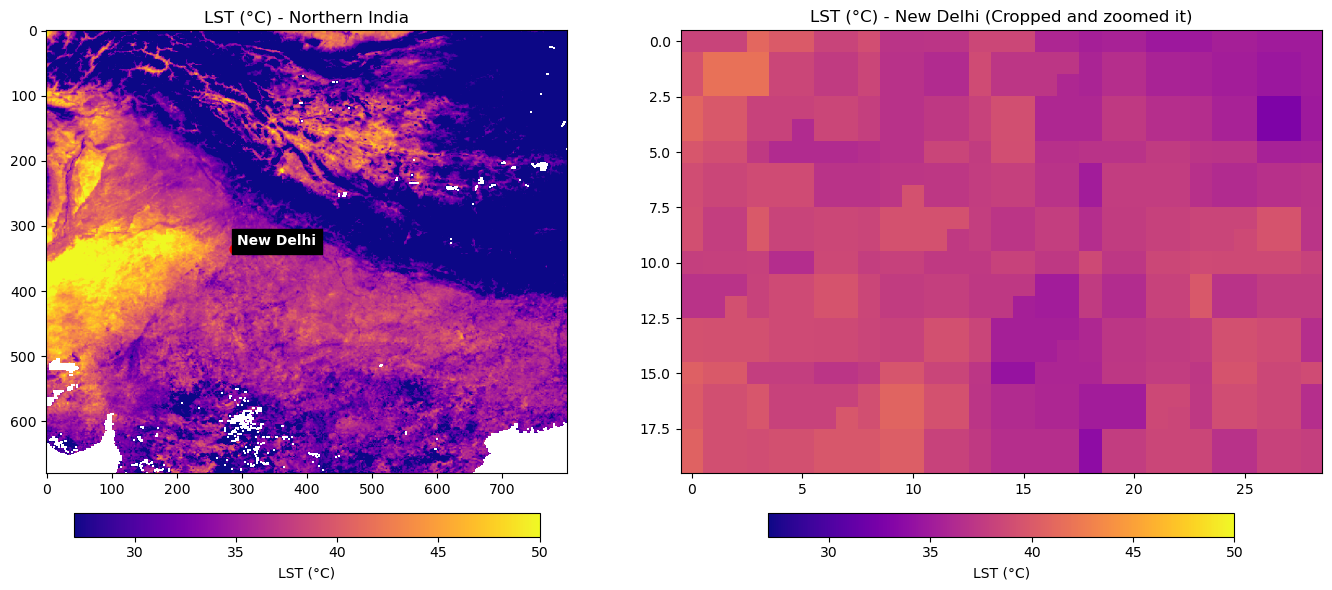

In [25]:
# Now we mask invalid or unrealistic values (sometimes satellite have artifacts or other issues that render the value of a pixel wrong)
arr[(arr <= 0) | (arr > 35000)] = np.nan

# Re-scale and convert from Kelvin to Celsius
arr_c = arr * 0.02 - 273.15  

# GeoTransform is a GDAL function that helps map between the raster coordinates and georeference coordinates
# In other words it is converting geographic coordinates (lat, lon) into pixel coordinates of our matrix (X, y)
gt = ds.GetGeoTransform()
def latlon_to_pixel(lat, lon, gt):
    px = int((lon - gt[0]) / gt[1])
    py = int((lat - gt[3]) / gt[5])
    return px, py

# Now we use this function to get the pixel coordinates of an area around Northern India 
lon_min, lon_max = 70, 90
lat_min, lat_max = 20, 37
px_min, py_max = latlon_to_pixel(lat_min, lon_min, gt)
px_max, py_min = latlon_to_pixel(lat_max, lon_max, gt)
# 'Bounding box of northern India'
arr_crop_india = arr_c[py_min:py_max, px_min:px_max]

# We do the same for New Dehli
lon_min, lon_max = 76.8, 77.5
lat_min, lat_max = 28.4, 28.9
px_min2, py_max2 = latlon_to_pixel(lat_min, lon_min, gt)
px_max2, py_min2 = latlon_to_pixel(lat_max, lon_max, gt)
arr_crop_delhi = arr_c[py_min2:py_max2, px_min2:px_max2]

# Selecting the color scheme 
cmap = "plasma"  # 🔴Change to other color schemes: 'inferno', 'cividis', 'jet'

# Settlings to ensure we have 2 plots, side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
vmin, vmax = 27, 50  #🔴can change here the max and min values for improved interpration

# 
im1 = axes[0].imshow(arr_crop_india, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0].set_title("LST (°C) - Northern India")
cbar1 = fig.colorbar(im1, ax=axes[0], orientation="horizontal", fraction=0.046, pad=0.08)
cbar1.set_label("LST (°C)")

# Mark New Delhi on Northern India map
delhi_lat, delhi_lon = 28.61, 77.21
px_delhi, py_delhi = latlon_to_pixel(delhi_lat, delhi_lon, gt)
px_delhi_rel = px_delhi - px_min
py_delhi_rel = py_delhi - py_min
axes[0].scatter(px_delhi_rel, py_delhi_rel, color="red", s=40, marker="o")
axes[0].text(px_delhi_rel + 5, py_delhi_rel - 5, "New Delhi", color="white",
             fontsize=10, weight="bold", backgroundcolor="black")

# Plot now 
im2 = axes[1].imshow(arr_crop_delhi, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1].set_title("LST (°C) - New Delhi (Cropped and zoomed it)")
cbar2 = fig.colorbar(im2, ax=axes[1], orientation="horizontal", fraction=0.046, pad=0.08)
cbar2.set_label("LST (°C)")

plt.tight_layout()
plt.show()


### 3.5 Identifying locations where Heatwave has occured in June 2024
- Applying a **threshold** (temperature limit from which it's considered to be a 'heatwave')

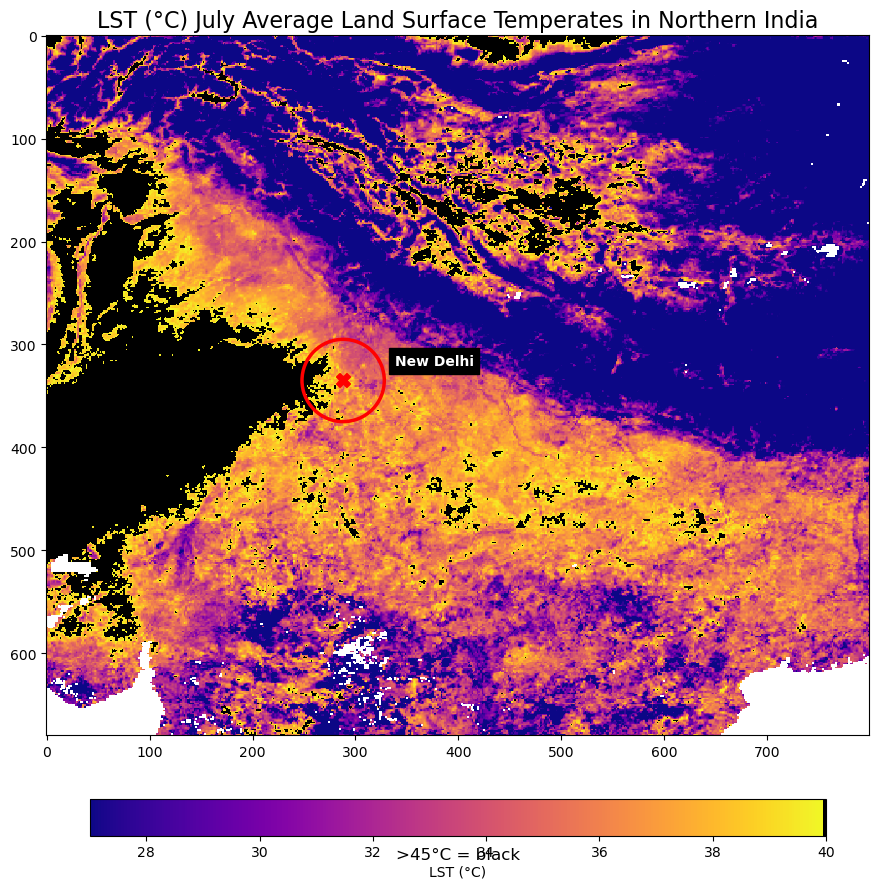

In [26]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors

# Start with the plasma colormap
base_cmap = plt.cm.plasma
newcolors = base_cmap(np.linspace(0, 1, 256))

# Make the last part of the colormap black (for >45 °C)
newcolors[-1, :] = [0, 0, 0, 1]  
cmap = mcolors.ListedColormap(newcolors)

# Setting the figure plot specifications 
fig, ax = plt.subplots(figsize=(12, 9)) 
vmin, vmax = 27, 40  # we extend vmax to allow space for black (>45 °C)
im = ax.imshow(arr_crop_india, cmap=cmap, vmin=vmin, vmax=vmax)

# Add colorbar
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", fraction=0.046, pad=0.08)
cbar.set_label("LST (°C)")

# Label explaining the threshold
cbar.ax.text(0.5, -0.5, ">45°C = black", color="black",
             fontsize=12, ha='center', va='center', transform=cbar.ax.transAxes)

ax.set_title("LST (°C) July Average Land Surface Temperates in Northern India", fontsize=16)

# Adding the coordinates of New Delhi again
delhi_lat, delhi_lon = 28.61, 77.21
px_delhi, py_delhi = latlon_to_pixel(delhi_lat, delhi_lon, gt)
px_delhi_rel = px_delhi - px_min
py_delhi_rel = py_delhi - py_min

# Adding a red X at New Delhi
ax.scatter(px_delhi_rel, py_delhi_rel, color="red", s=100, marker="X")

# Adding a big red circle around New Delhi
circle = patches.Circle((px_delhi_rel, py_delhi_rel), radius=40,
                        edgecolor='red', facecolor='none', linewidth=2.5)
ax.add_patch(circle)

# Label for New Delhi
ax.text(px_delhi_rel + 50, py_delhi_rel - 15, "New Delhi",
        color="white", fontsize=10, weight="bold", backgroundcolor="black")

plt.tight_layout()
plt.show()


# USE CASE 4: URBAN HEALTH

### 4.1. Import libraries

In [27]:
!pip install fastkml shapely
!pip install pykml

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [28]:
import requests
from IPython.display import Image
import mercantile

from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

import requests
from PIL import Image
from io import BytesIO

import mercantile
import numpy as np
from shapely.geometry import Polygon, Point
from pykml import parser

### 4.2. About the data: storage and access
- **DATA LOCATION:** Since this is on [**NASA VEDA data**](https://www.earthdata.nasa.gov/dashboard) - which is a **open-source cyberinfrascture** for data processing, visualization, exploration, and geographic information system (GIS) capabilties allows researchs to explore and analyze Earth science data in the cloud. This dataset, is physically stored in the veda-data-store S3 bucket.

<div style="text-align: center;">
    <img src="https://visex.netlify.app/graphics/nasa-veda-logo-pos.svg" width="100">
</div>

- **ABOUT DATA METADATA & ACCESS:** It is STAC (SpatioTemporal Asset Catalog) wich is a specification aimed to standardize the **way geospatial asset metadata is strucutred and queried**, estalbishing a standadd scheme and queryable. It is a metadata/catalog layer describing the dataset, making it easier to search and access. The access itself can be done through multiple ways:
<div style="text-align: center;">
    <img src="https://stacspec.org/public/images-original/STAC-01.png" width="100">
</div>

- 1) Browsed via STAC Browser (web-based browsing interface) - (aceess at https://radiantearth.github.io/stac-browser/#/?.language=en)
- 2) Uset STAC API (programmatic access) - STAC API allows to programmatically searcg/filter, and access STAC **using code**, rather than clicking through a web interface.
- 3) Diect S3 access (for AWS-hostet data) - this means you can access the **actuall files directly stored in S3 buckets withouth going through STAC browser or API interfaces**
- 4) Downloading it locally (if there is no need of authenticatio via S3)
- 5)...or  

### 4.2. Query the collection 
Before Processing, we can do some 'reconnaissance': understanding what data is available before you start working with it.

Found 1 item(s)
Item ID: povmap-grdi-v1_2010-01-01_2021-12-31
Available assets:
  - cog_default: s3://veda-data-store/grdi-v1-raster/povmap-grdi-v1_2010-01-01_2021-12-31.tif
  - rendered_preview: https://openveda.cloud/api/raster/collections/grdi-v1-raster/items/povmap-grdi-v1_2010-01-01_2021-12-31/preview.png?assets=cog_default&rescale=0%2C100&colormap_name=viridis


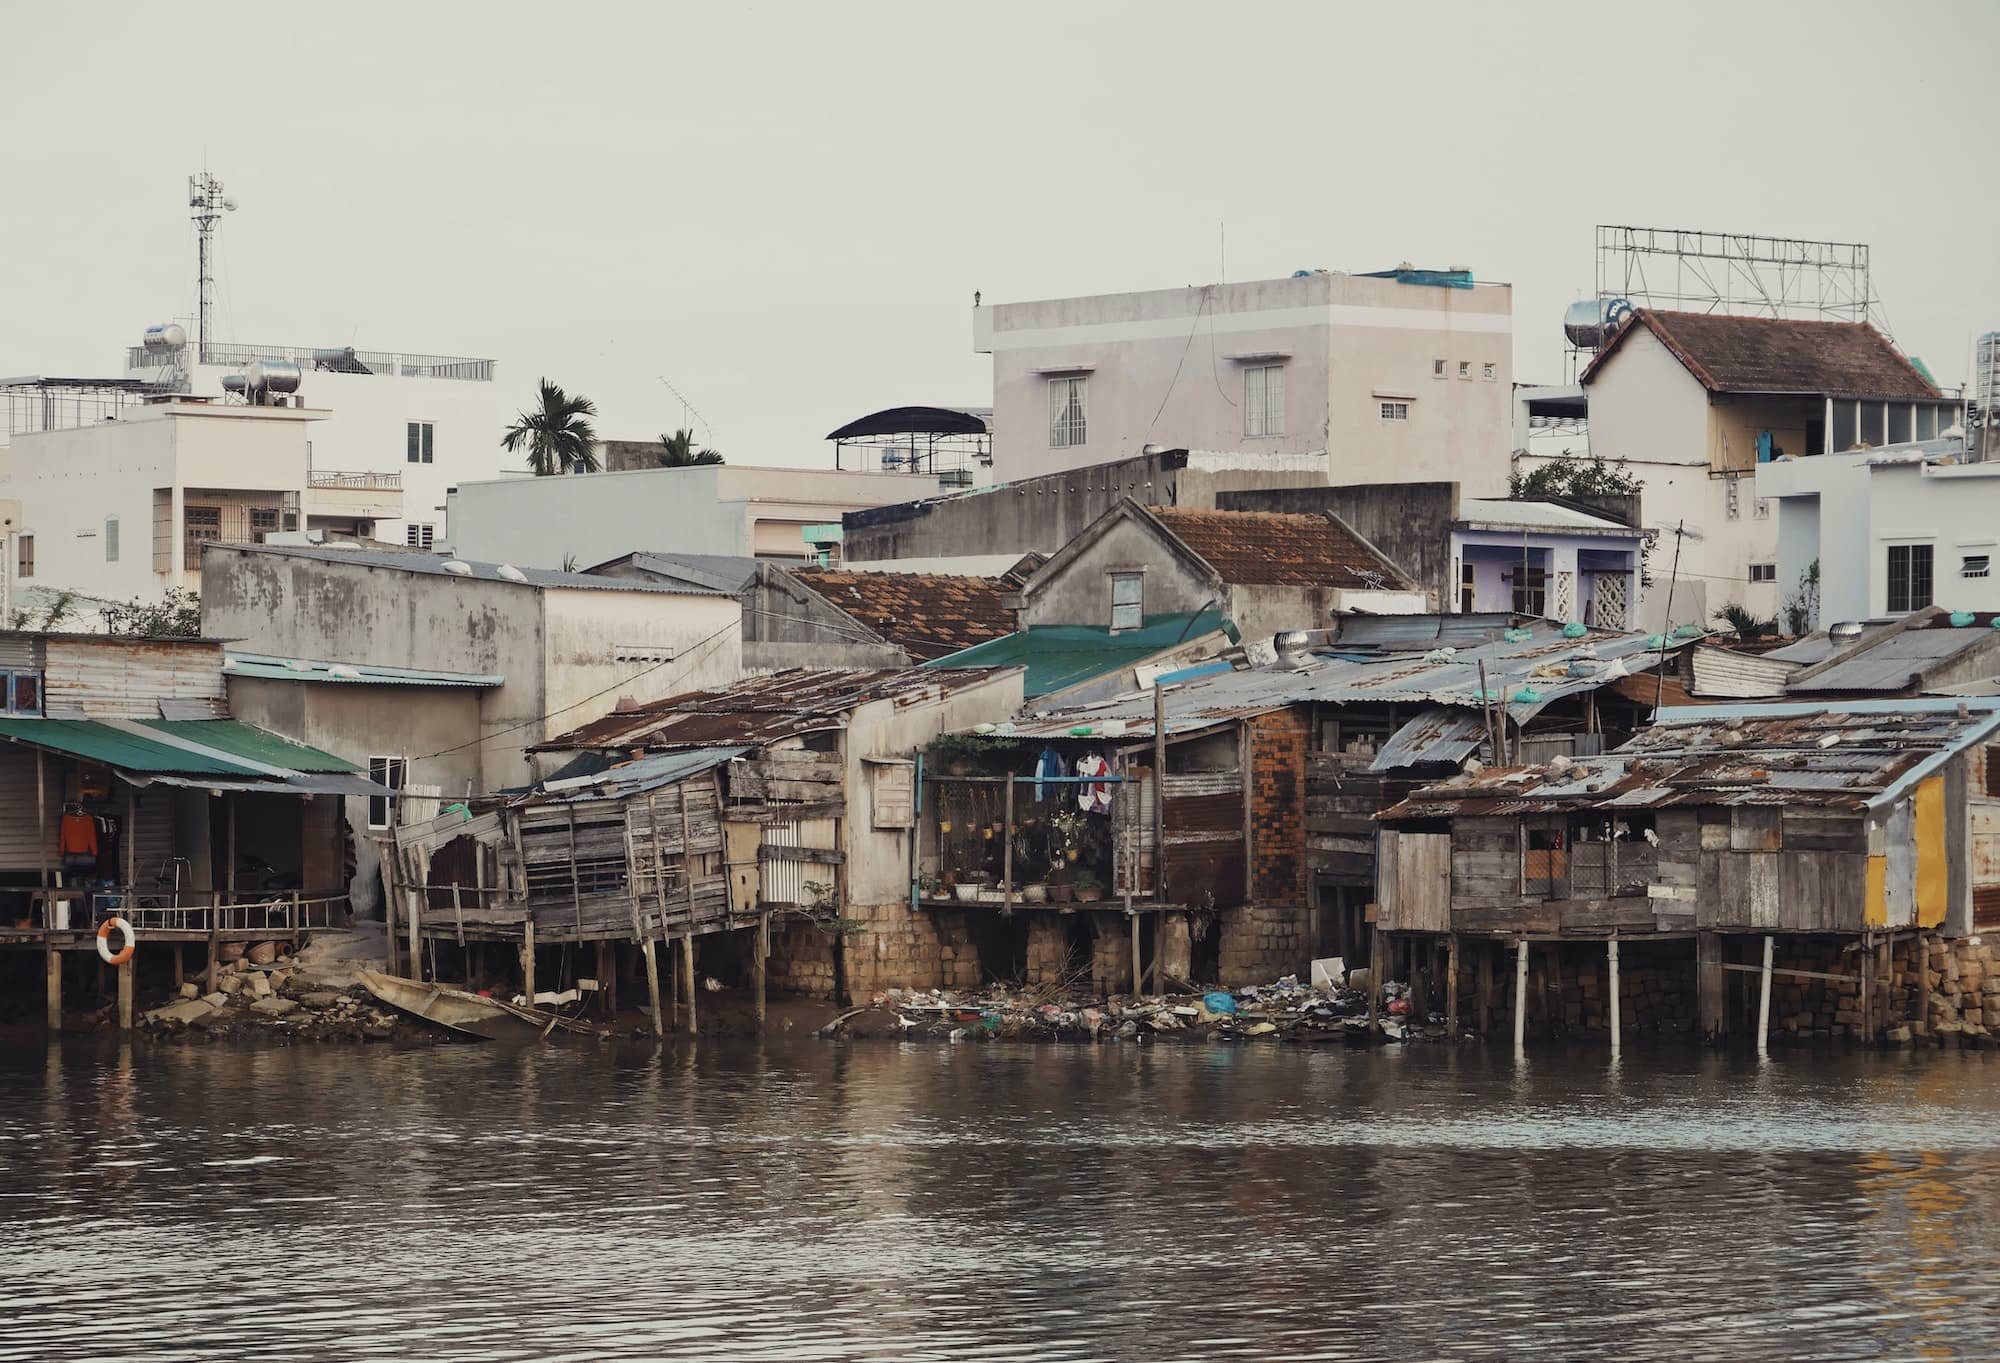

In [29]:
from PIL import Image
# Get all items in the GRDI STAC Collection
items_url = "https://openveda.cloud/api/stac/collections/grdi-v1-raster/items"
response = requests.get(items_url)
items = response.json()

print(f"Found {len(items['features'])} item(s)")

# Preview the first item
first_item = items["features"][0]
print("Item ID:", first_item["id"])
print("Available assets:")
for asset_name, asset in first_item["assets"].items():
    print(f"  - {asset_name}: {asset['href']}")

from PIL import Image
import requests
from io import BytesIO

thumbnail_url = "https://thumbnails.openveda.cloud/grdi--dataset-cover.jpg"
response = requests.get(thumbnail_url)
img = Image.open(BytesIO(response.content))
img.show()  # Opens in image viewer

### 4.3. Query the collection 
 - Some datasets may need registration or have usage agreements, so it might not be a straightforward process to access S3 AWS buckets - which can lead to **error 403**.

- In this case if we do not have permission we can convert the COG available on the link we descovered earlier into web map tiles, so it means VEDA API **handles S3 authentication**.

- The tile URL requests a small square of the GRDI map from Veda’s server, using zoom (z) and grid (x, y) coordinates in Web Mercator. Veda reads only the needed pixels from the large Cloud Optimized GeoTIFF (COG), applies the colormap, and sends it as an image—COG makes this efficient by allowing partial reads without loading the entire dataset.

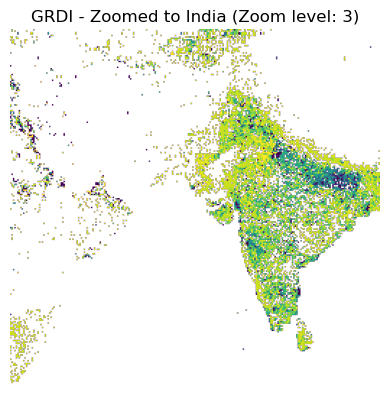

In [30]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import mercantile

# Coordinates over India
lon, lat = 78.96, 20.59
zoom = 3   ## 🔴Change here zoom
tile = mercantile.tile(lon, lat, zoom)

# Generate tile URL
base_url = "https://openveda.cloud/api/raster/cog/tiles/WebMercatorQuad"
cog_path = "s3://veda-data-store/grdi-v1-raster/povmap-grdi-v1_2010-01-01_2021-12-31.tif"  # 🟢COG of GRDI

cog_path = "s3://veda-data-store-staging/grdi-vnl-slope-raster/povmap-grdi-v1_VNL-slope_2012-01-01_2020-12-31.tif"  # 🟢COG of VNL slope

tile_url = (
    f"{base_url}/{tile.z}/{tile.x}/{tile.y}"
    f"?url={cog_path}&resampling_method=nearest&bidx=1"
    f"&colormap_name=viridis&rescale=0,100"
)

# Request and plot the tile
response = requests.get(tile_url)
img = Image.open(BytesIO(response.content))

plt.imshow(img)
plt.axis("off")
plt.title(f"GRDI - Zoomed to India (Zoom level: {zoom})")
plt.show()


### 4.4. Comparing values between two cities: New Delhi vs Gurugram 

#### 4.4.1 Load the KML

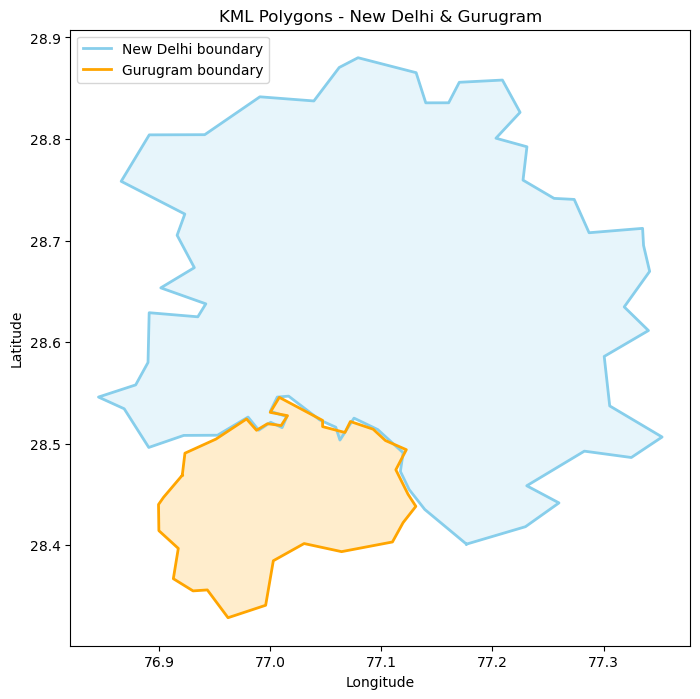

In [31]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pykml import parser

# --- Helper to read polygon from KML ---
def load_polygon(path):
    with open(path) as f:
        root = parser.parse(f).getroot()
    coords_text = root.Document.Placemark.Polygon.outerBoundaryIs.LinearRing.coordinates.text
    polygon_coords = [tuple(map(float, c.split(",")[:2])) for c in coords_text.strip().split()]
    return Polygon(polygon_coords)

# Load polygons
polygon_nd = load_polygon("Cities/NewDehli_2.kml")
polygon_gg = load_polygon("Cities/Gurugram.kml")

# --- Plot both polygons ---
fig, ax = plt.subplots(figsize=(8, 8))

# New Delhi in red
x_nd, y_nd = polygon_nd.exterior.xy
ax.plot(x_nd, y_nd, color="skyblue", linewidth=2, label="New Delhi boundary")
ax.fill(x_nd, y_nd, color="skyblue", alpha=0.2)

# Gurugram in green
x_gg, y_gg = polygon_gg.exterior.xy
ax.plot(x_gg, y_gg, color="orange", linewidth=2, label="Gurugram boundary")
ax.fill(x_gg, y_gg, color="orange", alpha=0.2)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("KML Polygons - New Delhi & Gurugram")
ax.legend()

plt.show()


In [32]:
import IPython.display
from shapely.geometry import Polygon
from pykml import parser
from sentinelhub import Geometry, CRS

# Loading the polygon from KML
def load_polygon_from_kml(kml_path):
    with open(kml_path) as f:
        root = parser.parse(f).getroot()
    coords_text = root.Document.Placemark.Polygon.outerBoundaryIs.LinearRing.coordinates.text
    polygon_coords = [tuple(map(float, c.split(",")[:2])) for c in coords_text.strip().split()]
    return Polygon(polygon_coords)

# Load polygons
polygon_gg = load_polygon_from_kml("Cities/Gurugram.kml")
polygon_nd = load_polygon_from_kml("Cities/NewDehli_2.kml")

# Convert to Sentinel Hub Geometry
geometry_gg = Geometry(polygon_gg, crs=CRS.WGS84)
geometry_nd = Geometry(polygon_nd, crs=CRS.WGS84)

# Display both as GeoJSON
IPython.display.GeoJSON({
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "geometry": geometry_gg.get_geojson(), "properties": {"name": "Gurugram"}},
        {"type": "Feature", "geometry": geometry_nd.get_geojson(), "properties": {"name": "New Delhi"}}
    ]
})


<IPython.display.GeoJSON object>


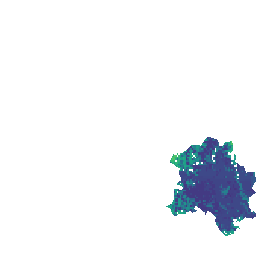
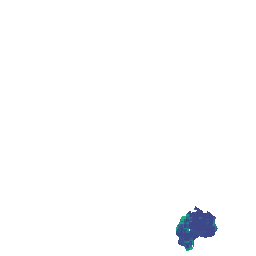

In [33]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import mercantile
from shapely.geometry import Point, Polygon, mapping
import folium
from folium.raster_layers import ImageOverlay
from pykml import parser

# Loading polygons
def load_polygon_from_kml(kml_path):
    with open(kml_path) as f:
        root = parser.parse(f).getroot()
    coords_text = root.Document.Placemark.Polygon.outerBoundaryIs.LinearRing.coordinates.text
    polygon_coords = [tuple(map(float, c.split(",")[:2])) for c in coords_text.strip().split()]
    return Polygon(polygon_coords)

# Fetch the COG into tile
def get_tile_image(lon, lat, zoom, cog_path, base_url):
    tile = mercantile.tile(lon, lat, zoom)
    url = (
        f"{base_url}/{tile.z}/{tile.x}/{tile.y}"
        f"?url={cog_path}&resampling_method=nearest&bidx=1"
        f"&colormap_name=viridis&rescale=0,100"
    )
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGBA")
    return np.array(img), tile

# Cropping tile to polyong of each city
def crop_to_polygon(img_array, tile, polygon):
    height, width = img_array.shape[:2]
    lon_ul, lat_ul = mercantile.ul(tile.x, tile.y, tile.z).lng, mercantile.ul(tile.x, tile.y, tile.z).lat
    lon_lr, lat_lr = mercantile.ul(tile.x+1, tile.y+1, tile.z).lng, mercantile.ul(tile.x+1, tile.y+1, tile.z).lat
    res_lon = (lon_lr - lon_ul) / width
    res_lat = (lat_lr - lat_ul) / height

    mask = np.zeros((height, width), dtype=bool)
    for i in range(height):
        for j in range(width):
            lon_p = lon_ul + j * res_lon
            lat_p = lat_ul + i * res_lat
            if polygon.contains(Point(lon_p, lat_p)):
                mask[i, j] = True
    img_array[~mask] = [0, 0, 0, 0]
    return img_array


zoom = 8
base_url = "https://openveda.cloud/api/raster/cog/tiles/WebMercatorQuad"
cog_path = "s3://veda-data-store/grdi-v1-raster/povmap-grdi-v1_2010-01-01_2021-12-31.tif"

#Loading polygons 
polygon_nd = load_polygon_from_kml("Cities/NewDehli_2.kml")
polygon_gg = load_polygon_from_kml("Cities/Gurugram.kml")

# Fetch and crop tiles ---
lon_nd, lat_nd = 77.209581, 28.646138
img_nd, tile_nd = get_tile_image(lon_nd, lat_nd, zoom, cog_path, base_url)
img_nd = crop_to_polygon(img_nd, tile_nd, polygon_nd)

lon_gg, lat_gg = 77.054362, 28.453160
img_gg, tile_gg = get_tile_image(lon_gg, lat_gg, zoom, cog_path, base_url)
img_gg = crop_to_polygon(img_gg, tile_gg, polygon_gg)

# Creating interactive map 
center_lat, center_lon = 28.55, 77.13
m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Add New Delhi overlay
ul_lat, ul_lon = mercantile.ul(tile_nd.x, tile_nd.y, tile_nd.z).lat, mercantile.ul(tile_nd.x, tile_nd.y, tile_nd.z).lng
lr_lat, lr_lon = mercantile.ul(tile_nd.x+1, tile_nd.y+1, tile_nd.z).lat, mercantile.ul(tile_nd.x+1, tile_nd.y+1, tile_nd.z).lng
ImageOverlay(image=img_nd, bounds=[[lr_lat, ul_lon], [ul_lat, lr_lon]], opacity=0.6).add_to(m)

# Add Gurugram overlay
ul_lat, ul_lon = mercantile.ul(tile_gg.x, tile_gg.y, tile_gg.z).lat, mercantile.ul(tile_gg.x, tile_gg.y, tile_gg.z).lng
lr_lat, lr_lon = mercantile.ul(tile_gg.x+1, tile_gg.y+1, tile_gg.z).lat, mercantile.ul(tile_gg.x+1, tile_gg.y+1, tile_gg.z).lng
ImageOverlay(image=img_gg, bounds=[[lr_lat, ul_lon], [ul_lat, lr_lon]], opacity=0.6).add_to(m)

# --- Add borders on top of raster overlays ---
# New Delhi border (skyblue)
folium.Polygon(
    locations=[(lat, lon) for lon, lat in polygon_nd.exterior.coords],
    color='skyblue',
    weight=3,
    fill=False
).add_to(m)

# Gurugram border (orange)
folium.Polygon(
    locations=[(lat, lon) for lon, lat in polygon_gg.exterior.coords],
    color='orange',
    weight=3,
    fill=False
).add_to(m)

# Display map
m



Average GRDI for New Delhi: 82.39458559144447
Average GRDI for Gurugram: 82.42232829070716


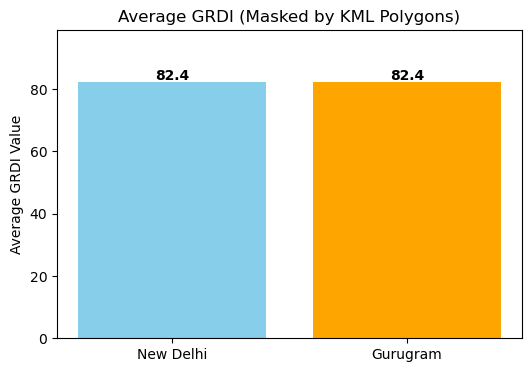

In [34]:


# Loading polyong from KML
def load_polygon(kml_path):
    with open(kml_path) as f:
        root = parser.parse(f).getroot()
    coords_text = root.Document.Placemark.Polygon.outerBoundaryIs.LinearRing.coordinates.text
    polygon_coords = [tuple(map(float, c.split(",")[:2])) for c in coords_text.strip().split()]
    return Polygon(polygon_coords)

# --- Helper: fetch one tile ---
base_url = "https://openveda.cloud/api/raster/cog/tiles/WebMercatorQuad"
cog_path = "s3://veda-data-store/grdi-v1-raster/povmap-grdi-v1_2010-01-01_2021-12-31.tif"

def fetch_tile(tile):
    url = (
        f"{base_url}/{tile.z}/{tile.x}/{tile.y}"
        f"?url={cog_path}&resampling_method=nearest&bidx=1"
        f"&colormap_name=viridis&rescale=0,100"
    )
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

# --- Function: compute masked average for a polygon ---
def compute_average_grdi(polygon, zoom=12):
    min_lon, min_lat, max_lon, max_lat = polygon.bounds
    tiles_to_fetch = list(mercantile.tiles(min_lon, min_lat, max_lon, max_lat, zoom))
    all_values = []

    for tile in tiles_to_fetch:
        img = fetch_tile(tile)
        img_array = np.array(img.convert("L"))
        
        mask = np.zeros(img_array.shape, dtype=bool)
        width, height = img.size

        # Upper-left corner of the tile
        lon_ul, lat_ul = mercantile.ul(tile.x, tile.y, tile.z).lng, mercantile.ul(tile.x, tile.y, tile.z).lat
        # Lower-right corner
        lon_lr, lat_lr = mercantile.ul(tile.x+1, tile.y+1, tile.z).lng, mercantile.ul(tile.x+1, tile.y+1, tile.z).lat
        # Resolution
        res_lon = (lon_lr - lon_ul) / width
        res_lat = (lat_lr - lat_ul) / height

        for i in range(height):
            for j in range(width):
                lon = lon_ul + j * res_lon
                lat = lat_ul + i * res_lat
                if polygon.contains(Point(lon, lat)):
                    mask[i, j] = True

        values = img_array[mask]
        all_values.extend(values)

    return np.mean(all_values) if all_values else np.nan

# --- Run for New Delhi and Gurugram ---
polygon_nd = load_polygon("Cities/NewDehli_2.kml")
polygon_gg = load_polygon("Cities/Gurugram.kml")

avg_nd = compute_average_grdi(polygon_nd, zoom=12)
avg_gg = compute_average_grdi(polygon_gg, zoom=12)

print("Average GRDI for New Delhi:", avg_nd)
print("Average GRDI for Gurugram:", avg_gg)


# --- Plot bar chart of masked GRDI averages ---
import matplotlib.pyplot as plt

averages = {
    "New Delhi": avg_nd,
    "Gurugram": avg_gg
}

plt.figure(figsize=(6, 4))
plt.bar(averages.keys(), averages.values(), color=['skyblue', 'orange'])
plt.ylabel("Average GRDI Value")
plt.title("Average GRDI (Masked by KML Polygons)")
for i, v in enumerate(averages.values()):
    plt.text(i, v + 0.5, f"{v:.1f}", ha='center', fontsize=10, fontweight='bold')
plt.ylim(0, max(averages.values()) * 1.2)
plt.show()




Average GRDI for New Delhi: 132.1962468386444
Average GRDI for Gurugram: 76.94425441170156


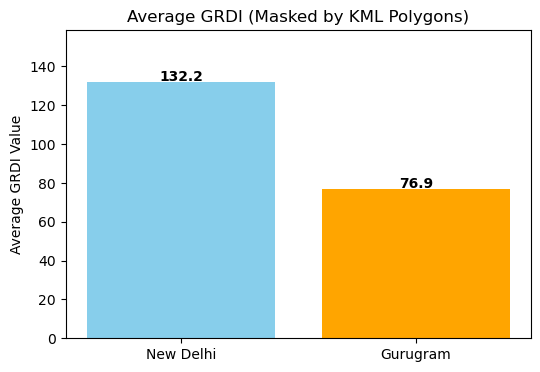

In [35]:


# Loading polyong from KML
def load_polygon(kml_path):
    with open(kml_path) as f:
        root = parser.parse(f).getroot()
    coords_text = root.Document.Placemark.Polygon.outerBoundaryIs.LinearRing.coordinates.text
    polygon_coords = [tuple(map(float, c.split(",")[:2])) for c in coords_text.strip().split()]
    return Polygon(polygon_coords)

# --- Helper: fetch one tile ---
base_url = "https://openveda.cloud/api/raster/cog/tiles/WebMercatorQuad"
#cog_path = "s3://veda-data-store/grdi-v1-raster/povmap-grdi-v1_2010-01-01_2021-12-31.tif"
cog_path = "s3://veda-data-store-staging/grdi-vnl-slope-raster/povmap-grdi-v1_VNL-slope_2012-01-01_2020-12-31.tif"

def fetch_tile(tile):
    url = (
        f"{base_url}/{tile.z}/{tile.x}/{tile.y}"
        f"?url={cog_path}&resampling_method=nearest&bidx=1"
        f"&colormap_name=viridis&rescale=0,100"
    )
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

# --- Function: compute masked average for a polygon ---
def compute_average_grdi(polygon, zoom=12):
    min_lon, min_lat, max_lon, max_lat = polygon.bounds
    tiles_to_fetch = list(mercantile.tiles(min_lon, min_lat, max_lon, max_lat, zoom))
    all_values = []

    for tile in tiles_to_fetch:
        img = fetch_tile(tile)
        img_array = np.array(img.convert("L"))
        
        mask = np.zeros(img_array.shape, dtype=bool)
        width, height = img.size

        # Upper-left corner of the tile
        lon_ul, lat_ul = mercantile.ul(tile.x, tile.y, tile.z).lng, mercantile.ul(tile.x, tile.y, tile.z).lat
        # Lower-right corner
        lon_lr, lat_lr = mercantile.ul(tile.x+1, tile.y+1, tile.z).lng, mercantile.ul(tile.x+1, tile.y+1, tile.z).lat
        # Resolution
        res_lon = (lon_lr - lon_ul) / width
        res_lat = (lat_lr - lat_ul) / height

        for i in range(height):
            for j in range(width):
                lon = lon_ul + j * res_lon
                lat = lat_ul + i * res_lat
                if polygon.contains(Point(lon, lat)):
                    mask[i, j] = True

        values = img_array[mask]
        all_values.extend(values)

    return np.mean(all_values) if all_values else np.nan

# --- Run for New Delhi and Gurugram ---
polygon_nd = load_polygon("Cities/NewDehli_2.kml")
polygon_gg = load_polygon("Cities/Gurugram.kml")

avg_nd = compute_average_grdi(polygon_nd, zoom=12)
avg_gg = compute_average_grdi(polygon_gg, zoom=12)

print("Average GRDI for New Delhi:", avg_nd)
print("Average GRDI for Gurugram:", avg_gg)


# --- Plot bar chart of masked GRDI averages ---
import matplotlib.pyplot as plt

averages = {
    "New Delhi": avg_nd,
    "Gurugram": avg_gg
}

plt.figure(figsize=(6, 4))
plt.bar(averages.keys(), averages.values(), color=['skyblue', 'orange'])
plt.ylabel("Average GRDI Value")
plt.title("Average GRDI (Masked by KML Polygons)")
for i, v in enumerate(averages.values()):
    plt.text(i, v + 0.5, f"{v:.1f}", ha='center', fontsize=10, fontweight='bold')
plt.ylim(0, max(averages.values()) * 1.2)
plt.show()


